#  Taxi Demand Forecasting

Project objective: predict the number of taxi orders for the next hour so that the aggregator can attract more drivers during the peak period. The data is provided by Yandex.Taxi service.

Condition: for the project to be accepted, the *RMSE* metric value on the test sample should be less than 48.

Key words: 
- Python
- Pandas
- Time Series
- Scikit-learn
- Boosting

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li>
    <li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li>
    <li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item">
        <li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Decision Tree</a></span></li>
        <li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li>
        <li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li>
        <li><span><a href="#Boosting" data-toc-modified-id="Boosting-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Boosting</a></span></li>
        </ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li>
    <li><span><a href="#Visualization-of-results" data-toc-modified-id="Visualization-of-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualization of results</a></span></li>

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('C:\\Users\\Яна\\Documents\\Прогр\\dfs\\taxi.csv', index_col = [0], parse_dates = [0])

df.info()
print()
print('Is monotonic:', df.index.is_monotonic)
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Is monotonic: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Dataset pleases with its smallness!

No missing values, time series is monotonic. It remains to resampling.

In [3]:
df = df.resample('1H').sum()
display(df.head())
df.shape

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


(4416, 1)

## Analysis

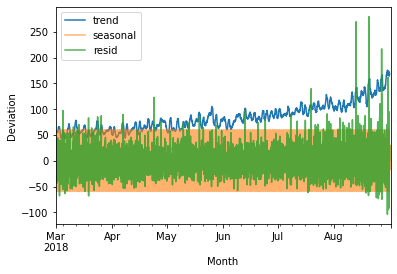

In [4]:
decomposed = seasonal_decompose(df)

decomposed.trend.plot()
decomposed.seasonal.plot(alpha = 0.6)
decomposed.resid.plot(alpha = 0.8)

plt.xlabel('Month')
plt.ylabel('Deviation')
plt.legend()
plt.show()

The chart clearly shows an uptrend. Seasonality is not expressed. Most of the fluctuations is in the resid.

The table presents data for half a year, and there is really no reason to expect any cyclicality in the interval from March to August. But at shorter intervals, cyclicity may appear. Let's check.

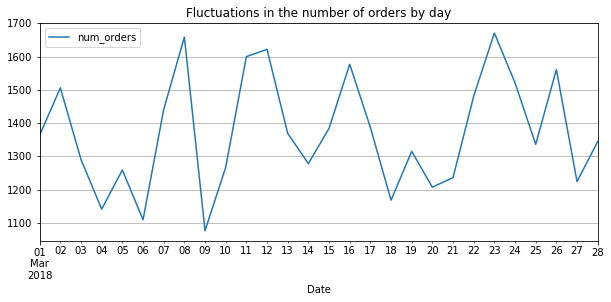

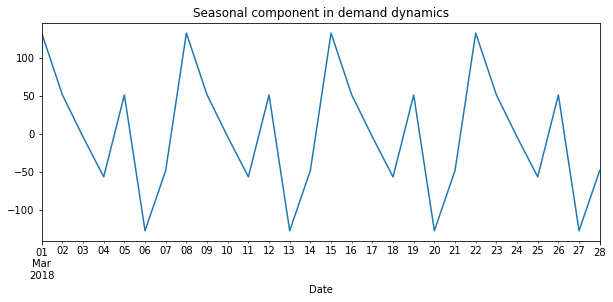

In [5]:
df_week = df['2018-03-01':'2018-03-28'].resample('1D').sum()

df_week.plot(grid = True, figsize = (10, 4))
plt.title('Fluctuations in the number of orders by day')
plt.xlabel('Date')
plt.show()

decomposed_week = seasonal_decompose(df_week)

decomposed_week.seasonal.plot(figsize = (10, 4))
plt.title('Seasonal component in demand dynamics')
plt.xlabel('Date')
plt.show()

Visually the weekly cycle is not noticeable. But if we single out the seasonal component, the weekly cycle becomes quite obvious. So I'll add a "day of the week" column to the table as a learning feature.

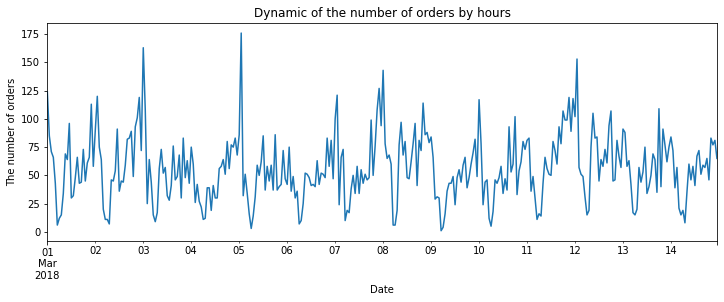

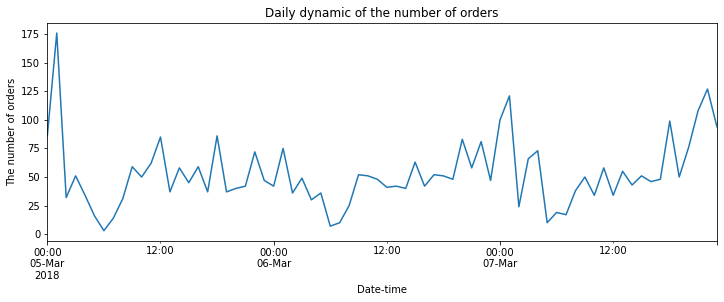

In [6]:
df['num_orders']['2018-03-01':'2018-03-14'].plot(figsize = (12, 4))
plt.title('Dynamic of the number of orders by hours')
plt.xlabel('Date')
plt.ylabel('The number of orders')
plt.show()

df['num_orders']['2018-03-05':'2018-03-07'].plot(figsize = (12, 4))
plt.title('Daily dynamic of the number of orders')
plt.xlabel('Date-time')
plt.ylabel('The number of orders')
plt.show()

In addition to the weekly cycle, it is logical to assume the presence of a daily cycle. Let's check its presence.

Daily seasonality here is visible even without division into components. For clarity, I brought out a graph for three days - every day we see a peak around midnight, then a decline at six in the morning. The next peak falls on the pre-lunch time, after 12 some decline, and further growth until midnight. So I'll add the "hour" as a feature to the table.

In [7]:
df['week_day'] = df.index.dayofweek
df['hour'] = df.index.hour
display(df.head())

,num_orders,week_day,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Adding new columns.

In [8]:
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)
df['lag_4'] = df['num_orders'].shift(4)
df['lag_5'] = df['num_orders'].shift(5)
df['lag_6'] = df['num_orders'].shift(6)
df['lag_7'] = df['num_orders'].shift(7)
df['lag_8'] = df['num_orders'].shift(8)

Adding enough lags.

In [9]:
df['rolling_mean_24'] = df['num_orders'].rolling(24).mean()
df['rolling_mean_12'] = df['num_orders'].rolling(12).mean()
df['rolling_mean_48'] = df['num_orders'].rolling(48).mean()
df['rolling_mean_6'] = df['num_orders'].rolling(6).mean()

Adding columns with the rolling means.

In [10]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4369 entries, 2018-03-02 23:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4369 non-null   int64  
 1   week_day         4369 non-null   int64  
 2   hour             4369 non-null   int64  
 3   lag_1            4369 non-null   float64
 4   lag_2            4369 non-null   float64
 5   lag_3            4369 non-null   float64
 6   lag_4            4369 non-null   float64
 7   lag_5            4369 non-null   float64
 8   lag_6            4369 non-null   float64
 9   lag_7            4369 non-null   float64
 10  lag_8            4369 non-null   float64
 11  rolling_mean_24  4369 non-null   float64
 12  rolling_mean_12  4369 non-null   float64
 13  rolling_mean_48  4369 non-null   float64
 14  rolling_mean_6   4369 non-null   float64
dtypes: float64(12), int64(3)
memory usage: 546.1 KB


Dropping missings and checking final info. Looks like we are ready to train models!

## Training

In [11]:
df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)

features_train = df_train.drop('num_orders', axis = 1)
target_train = df_train['num_orders']

features_test = df_test.drop('num_orders', axis = 1)
target_test = df_test['num_orders']

Split the data into train and test samples. Test sample is 10% of the general sample.

In [12]:
tscv = TimeSeriesSplit(n_splits = 8)

Declare a variable with special time Series cross-validator to avoid data leakage.

### Decision Tree

In [13]:
model_DTR = DecisionTreeRegressor(random_state = 12345)
params_DTR = {'max_depth': range(2, 6), 
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(2, 10)}

grid = GridSearchCV(model_DTR, params_DTR, cv = tscv)

grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [14]:
model_DTR = DecisionTreeRegressor(max_depth = 5, min_samples_split = 2,
                                  min_samples_leaf = 9, random_state = 12345)

model_DTR.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=9, random_state=12345)

Finding optimal parameters with the greed search and fitting the model.

### Random Forest

In [15]:
model_RFR = RandomForestRegressor(random_state = 12345)
params_RFR = {'n_estimators': range(20, 81, 10),
              'max_depth': range(3, 16),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(2, 8)}

grid = GridSearchCV(model_RFR, params_RFR, cv = tscv, n_jobs = -1)

grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 80}

In [16]:
model_RFR = RandomForestRegressor(n_estimators = 80, max_depth = 15, min_samples_split = 2,
                                  min_samples_leaf = 2, random_state = 12345)

model_RFR.fit(features_train, target_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=80,
                      random_state=12345)

### Linear Regression

In [17]:
model_LR = LinearRegression()
params_LR = {'fit_intercept': [True, False],
              'normalize': [True, False]}


grid = GridSearchCV(model_LR, params_LR, cv = tscv, n_jobs = -1)

grid.fit(features_train, target_train)

grid.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


{'fit_intercept': True, 'normalize': True}

In [18]:
model_LR = LinearRegression(fit_intercept = True, normalize = True)
model_LR.fit(features_train, target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

### Boosting

In [19]:
model_CBR = CatBoostRegressor(random_state = 12345)

params_CBR  = {'n_estimators': range(150, 351, 50),
               'depth': range(3, 7)}

grid = GridSearchCV(model_CBR, params_CBR, cv = tscv, n_jobs = -1)

grid.fit(features_train, target_train)

grid.best_params_

Learning rate set to 0.119344
0:	learn: 36.7529091	total: 136ms	remaining: 47.4s
1:	learn: 35.0796212	total: 137ms	remaining: 23.9s
2:	learn: 33.6798386	total: 139ms	remaining: 16.1s
3:	learn: 31.9989035	total: 141ms	remaining: 12.2s
4:	learn: 30.4408032	total: 142ms	remaining: 9.82s
5:	learn: 29.2614174	total: 144ms	remaining: 8.26s
6:	learn: 28.2324695	total: 146ms	remaining: 7.14s
7:	learn: 27.6222476	total: 147ms	remaining: 6.29s
8:	learn: 26.7885301	total: 149ms	remaining: 5.64s
9:	learn: 26.0577225	total: 151ms	remaining: 5.12s
10:	learn: 25.5863538	total: 152ms	remaining: 4.69s
11:	learn: 25.2048913	total: 154ms	remaining: 4.34s
12:	learn: 24.8435034	total: 156ms	remaining: 4.04s
13:	learn: 24.4628684	total: 157ms	remaining: 3.78s
14:	learn: 24.2066687	total: 159ms	remaining: 3.55s
15:	learn: 23.9027913	total: 161ms	remaining: 3.35s
16:	learn: 23.6188037	total: 162ms	remaining: 3.18s
17:	learn: 23.4069801	total: 164ms	remaining: 3.02s
18:	learn: 23.1617892	total: 166ms	remaining

202:	learn: 11.8248736	total: 522ms	remaining: 378ms
203:	learn: 11.8017469	total: 524ms	remaining: 375ms
204:	learn: 11.7666932	total: 526ms	remaining: 372ms
205:	learn: 11.7239712	total: 528ms	remaining: 369ms
206:	learn: 11.6931456	total: 530ms	remaining: 366ms
207:	learn: 11.6592595	total: 532ms	remaining: 363ms
208:	learn: 11.6225175	total: 534ms	remaining: 360ms
209:	learn: 11.5862975	total: 536ms	remaining: 357ms
210:	learn: 11.5428143	total: 538ms	remaining: 354ms
211:	learn: 11.5137786	total: 540ms	remaining: 351ms
212:	learn: 11.4878358	total: 542ms	remaining: 348ms
213:	learn: 11.4555285	total: 544ms	remaining: 345ms
214:	learn: 11.4325680	total: 546ms	remaining: 343ms
215:	learn: 11.3977302	total: 548ms	remaining: 340ms
216:	learn: 11.3613959	total: 549ms	remaining: 337ms
217:	learn: 11.3312260	total: 551ms	remaining: 334ms
218:	learn: 11.3052215	total: 553ms	remaining: 331ms
219:	learn: 11.2784884	total: 555ms	remaining: 328ms
220:	learn: 11.2515265	total: 557ms	remaining:

{'depth': 5, 'n_estimators': 350}

In [20]:
model_CBR = CatBoostRegressor(n_estimators = 350, depth = 5, random_state = 12345)
model_CBR.fit(features_train, target_train)

Learning rate set to 0.119344
0:	learn: 36.7529091	total: 25.3ms	remaining: 8.83s
1:	learn: 35.0796212	total: 28.2ms	remaining: 4.9s
2:	learn: 33.6798386	total: 31ms	remaining: 3.58s
3:	learn: 31.9989035	total: 33.5ms	remaining: 2.89s
4:	learn: 30.4408032	total: 35.4ms	remaining: 2.44s
5:	learn: 29.2614174	total: 37.4ms	remaining: 2.14s
6:	learn: 28.2324695	total: 39.5ms	remaining: 1.94s
7:	learn: 27.6222476	total: 41.5ms	remaining: 1.77s
8:	learn: 26.7885301	total: 43.4ms	remaining: 1.64s
9:	learn: 26.0577225	total: 45.5ms	remaining: 1.55s
10:	learn: 25.5863538	total: 48.3ms	remaining: 1.49s
11:	learn: 25.2048913	total: 50.6ms	remaining: 1.42s
12:	learn: 24.8435034	total: 52.6ms	remaining: 1.36s
13:	learn: 24.4628684	total: 54.8ms	remaining: 1.31s
14:	learn: 24.2066687	total: 57.5ms	remaining: 1.28s
15:	learn: 23.9027913	total: 59.7ms	remaining: 1.25s
16:	learn: 23.6188037	total: 61.6ms	remaining: 1.21s
17:	learn: 23.4069801	total: 63.6ms	remaining: 1.17s
18:	learn: 23.1617892	total: 

166:	learn: 13.1214548	total: 344ms	remaining: 377ms
167:	learn: 13.0927400	total: 346ms	remaining: 375ms
168:	learn: 13.0534400	total: 347ms	remaining: 372ms
169:	learn: 13.0113837	total: 349ms	remaining: 369ms
170:	learn: 12.9704189	total: 351ms	remaining: 367ms
171:	learn: 12.9427022	total: 353ms	remaining: 365ms
172:	learn: 12.8900079	total: 355ms	remaining: 363ms
173:	learn: 12.8597477	total: 356ms	remaining: 360ms
174:	learn: 12.8148873	total: 358ms	remaining: 358ms
175:	learn: 12.7736388	total: 360ms	remaining: 356ms
176:	learn: 12.7518830	total: 361ms	remaining: 353ms
177:	learn: 12.7072233	total: 363ms	remaining: 351ms
178:	learn: 12.6814860	total: 365ms	remaining: 348ms
179:	learn: 12.6374106	total: 366ms	remaining: 346ms
180:	learn: 12.5942537	total: 368ms	remaining: 344ms
181:	learn: 12.5578109	total: 370ms	remaining: 341ms
182:	learn: 12.5206060	total: 372ms	remaining: 339ms
183:	learn: 12.4727078	total: 373ms	remaining: 337ms
184:	learn: 12.4449585	total: 375ms	remaining:

346:	learn: 8.4878852	total: 677ms	remaining: 5.86ms
347:	learn: 8.4731504	total: 679ms	remaining: 3.9ms
348:	learn: 8.4621907	total: 681ms	remaining: 1.95ms
349:	learn: 8.4478704	total: 683ms	remaining: 0us


## Testing

Now let's check RMSE of the models on the test set.

In [21]:
predictions_DTR = model_DTR.predict(features_test)

rmse_DTR = mean_squared_error(target_test, predictions_DTR, squared=False)
print(rmse_DTR)

53.29049372044128


Decision Tree - 53.2. Not very good.

In [22]:
predictions_RFR = model_RFR.predict(features_test)

rmse_RFR = mean_squared_error(target_test, predictions_RFR, squared=False)
print(rmse_RFR)

39.97115579923948


Random forest - 40. Better, but still not good enough.

In [23]:
predictions_LR = model_LR.predict(features_test)

rmse_LR = mean_squared_error(target_test, predictions_LR, squared=False)
print(rmse_LR)

1.7006894511213327e-13


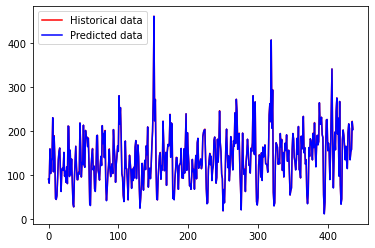

In [24]:
a=np.array(target_test, np.int32)
b=np.array(predictions_LR, np.int32)

plt.plot(a, color = 'red', label = 'Historical data')
plt.plot(b, color = 'blue', label='Predicted data')
plt.legend()
plt.show()

WoW! Linear regression making a great result! The reviewer said that this is a record accuracy for this project (the previous record for this project was RMSE = 8).

In [25]:
predictions_CBR = model_CBR.predict(features_test)

rmse_CBR = mean_squared_error(target_test, predictions_CBR, squared=False)
print(rmse_CBR)

37.622974577069215


CatBoost also shows a medium result, 37.6. So viva la linear regression!

## Visualization of results

Linear regression predictions, judging by RMSE, should almost exactly repeat the real data. Let's see with our eyes.

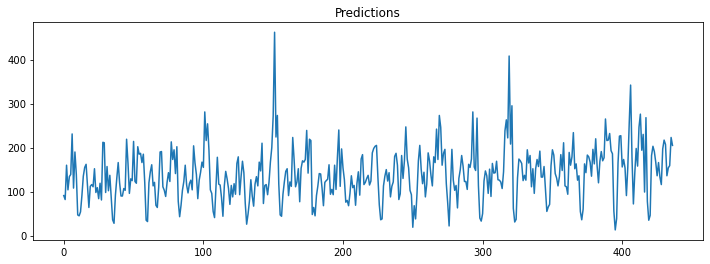

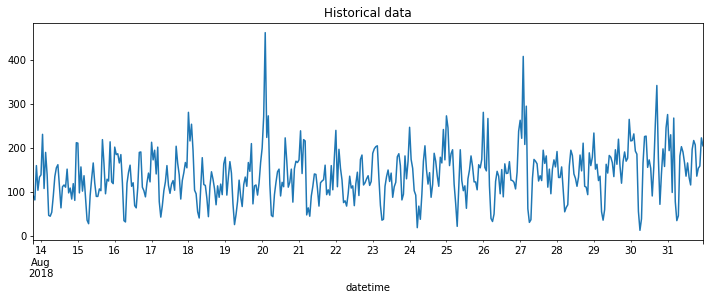

In [26]:
plr = pd.Series(predictions_LR)
plr.plot(figsize = (12, 4))
plt.title('Predictions')
plt.show()

target_test.plot(figsize = (12, 4))
plt.title('Historical data')
plt.show()

Graphs are almost identical.

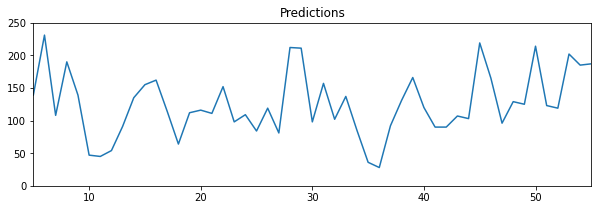

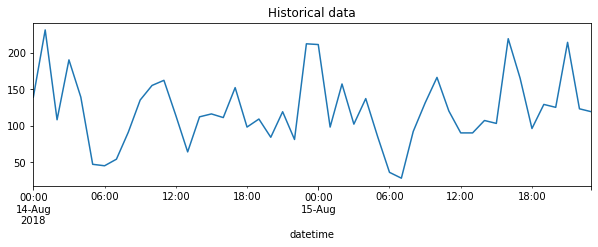

In [27]:
plr.plot(figsize = (10, 3))
plt.title('Predictions')
plt.xlim(5, 55)
plt.ylim(0, 250)
plt.show()

target_test['2018-08-14':'2018-08-15'].plot(figsize = (10, 3))
plt.title('Historical data')
plt.show()

Graphs for two days - they also show the almost complete coincidence of the forecast with reality.